In [1]:
import json
import os
import time
import sys

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

NUM_KEYPOINTS = 16*2
EPOCHS = NUM_KEYPOINTS*3

BASE_LEARNING_RATE = 1e-4

In [5]:
IMG_DIR = "datasets/mpii/images_selected/"
JSON = "datasets/mpii/trainval.json"

with open(JSON) as infile:
    json_data = json.load(infile)


json_dict = {i["image"]: i for i in json_data}

In [6]:
for k in json_dict.keys():
    for i in range(0,16):
        json_dict[k]['joints'][i].append(json_dict[k]['joints_vis'][i])
    del json_dict[k]['joints_vis']

In [7]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [8]:
def get(name):
    data = json_dict[name]
    img_data = plt.imread(IMG_DIR + data["image"])

    data["img_data"] = img_data

    return data

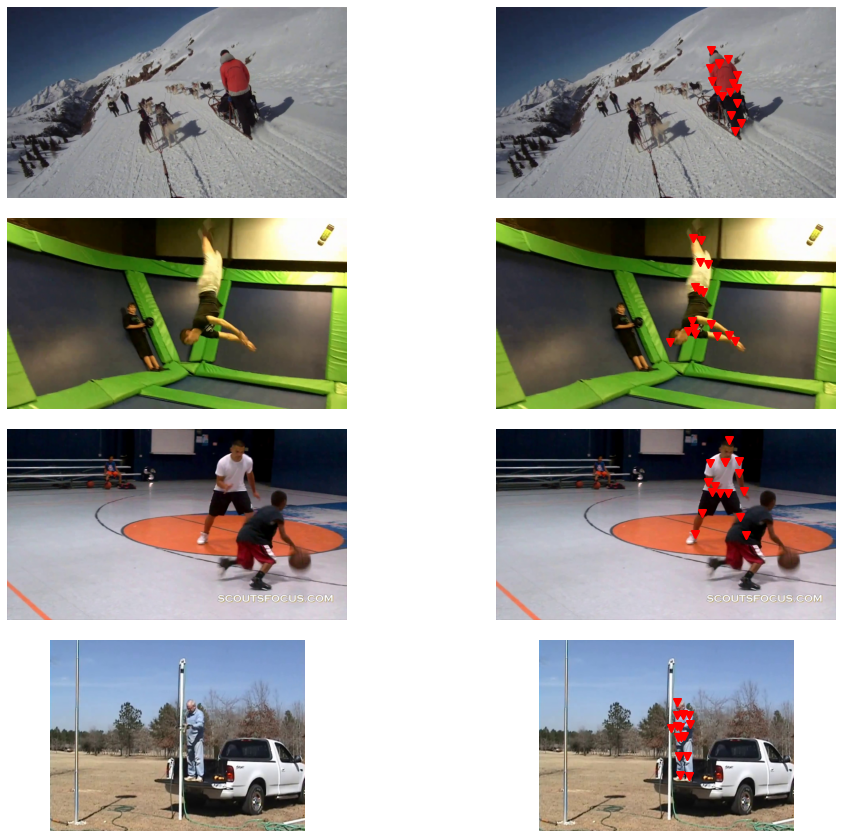

In [9]:

def compare_keypoints(images, keypoints, predicted_keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint, current_pred_keypoint in zip(axes, images, keypoints, predicted_keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

     
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c='green', marker="v", s=50, linewidths=2
                )
        else:
            current_keypoint = np.array(current_keypoint)
            print(current_keypoint)
            for idx, (kp) in enumerate(current_keypoint):
                ax_all.scatter([kp.x], [kp.y], c='green', marker="v", s=50, linewidths=2)
                
        if isinstance(current_pred_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_pred_keypoint.keypoints):
                ax_orig.scatter(
                    [kp.x], [kp.y], c='red', marker="v", s=50, linewidths=2
                )
        else:
            current_pred_keypoint = np.array(current_pred_keypoint)
       
            print(current_pred_keypoint)
            for i in range(0,16,2):
                ax_orig.scatter([current_pred_keypoint[i]], [current_pred_keypoint[i+1]], c='red', marker="v", s=50, linewidths=2)

    plt.tight_layout(pad=2.0)
    plt.show()


def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

       
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c='red', marker="v", s=50, linewidths=2
                )
        else:
            current_keypoint = np.array(current_keypoint)
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c='red', marker="v", s=50, linewidths=2)

    plt.tight_layout(pad=2.0)
    plt.show()


samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

In [10]:
class KeyPointsDataset(tf.keras.utils.Sequence):
    
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            
            #data = get(key)
            
            data = json_dict[key]
            img_data = plt.imread(IMG_DIR + data["image"])


            
            
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

        
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            kps_obj = KeypointsOnImage(kps, shape=img_data.shape)

            (new_image, new_kps_obj) = self.aug(image=img_data, keypoints=kps_obj)
            batch_images[i,] = new_image

            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, NUM_KEYPOINTS)
            del data

        batch_keypoints = batch_keypoints / IMG_SIZE


        
        return (batch_images, batch_keypoints)

In [11]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)

Total batches in training set: 464
Total batches in validation set: 82


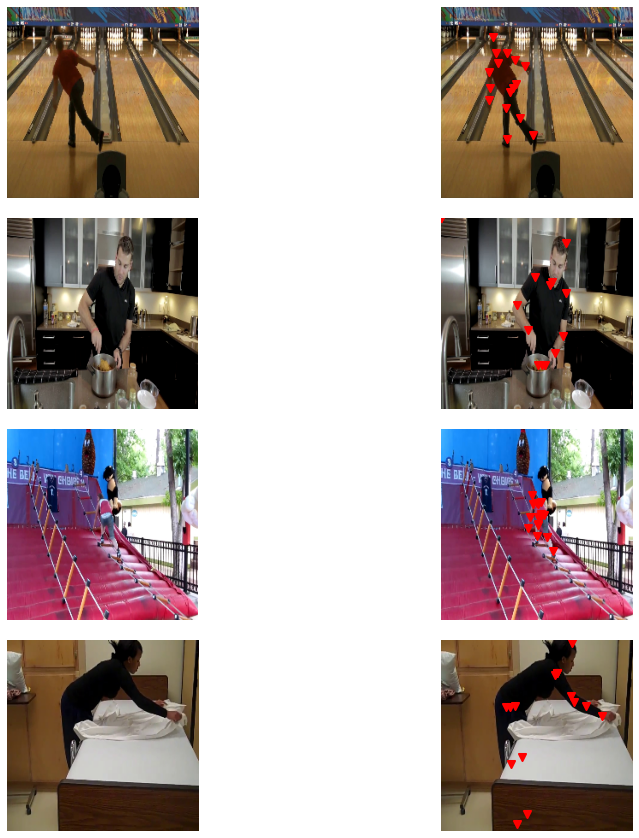

In [12]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))

sample_keypoints = sample_keypoints[:4].reshape(-1, 16, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

In [13]:
backbone = tf.keras.applications.MobileNetV3Small(
    weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

In [17]:
inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
x = backbone(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.SeparableConv2D(
    NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
)(x)
outputs = tf.keras.layers.SeparableConv2D(
    NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
)(x)

model = tf.keras.Model(inputs, outputs, name="keypoint_detector")

model.summary()

Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 7, 576)         0         
                                                                 
 separable_conv2d (Separable  (None, 3, 3, 32)         32864     
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 1, 1, 32)         1344      
 leConv2D)                                                       
                                                 

In [ ]:
# inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
# x = tf.keras.applications.resnet.preprocess_input(inputs)
# x = backbone(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.SeparableConv2D(
#     NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
# )(x)
# outputs = tf.keras.layers.SeparableConv2D(
#     NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
# )(x)

# model = tf.keras.Model(inputs, outputs, name="keypoint_detector")

# model.summary()

In [ ]:
# inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
# x = tf.keras.applications.resnet.preprocess_input(inputs)
# x = backbone(x)

# x = tf.keras.layers.Flatten()(x)
# NEURONS = 1000
# x = tf.keras.layers.Dense(NEURONS, activation='relu')(x)
# outputs = tf.keras.layers.Dense(NUM_KEYPOINTS, activation = 'softmax')(x)


# model = tf.keras.Model(inputs, outputs, name="keypoint_detector")

# model.summary()

In [ ]:
# inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
# x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
# x = backbone(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.SeparableConv2D(
#     576, kernel_size=5, strides=1, activation="relu"
# )(x)
# x = tf.keras.layers.SeparableConv2D(
#     576, kernel_size=3, strides=1, activation="sigmoid"
# )(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(NUM_KEYPOINTS, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.3)(x)
# x = tf.keras.layers.Dense(NUM_KEYPOINTS, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.3)(x)
# outputs = tf.keras.layers.Dense(NUM_KEYPOINTS, activation='softmax')(x)

# model = tf.keras.Model(inputs, outputs, name="keypoint_detector")

# model.summary()

In [18]:
#model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE),metrics=['accuracy'], run_eagerly=True)
# model.compile(optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()], run_eagerly=True)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(),'accuracy'])
# model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE),metrics=['mae'], run_eagerly=True)
# model.compile(optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE), loss='mse')

In [20]:
#model.load_weights('saved_model/finetuned_model.h5')
backbone.trainable = False
model.load_weights('saved_model/before_finetuning_model.h5')

1/1 [==============================] - 2s 2s/step


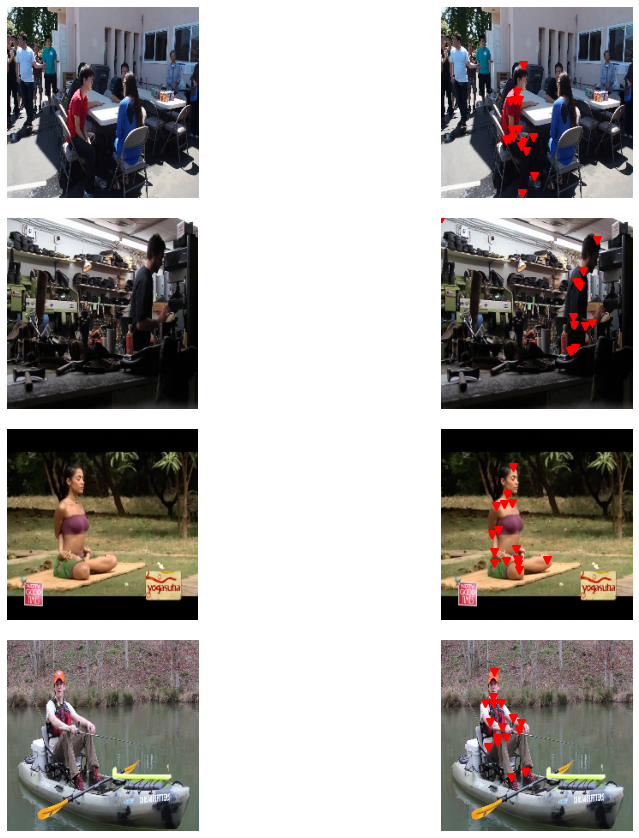

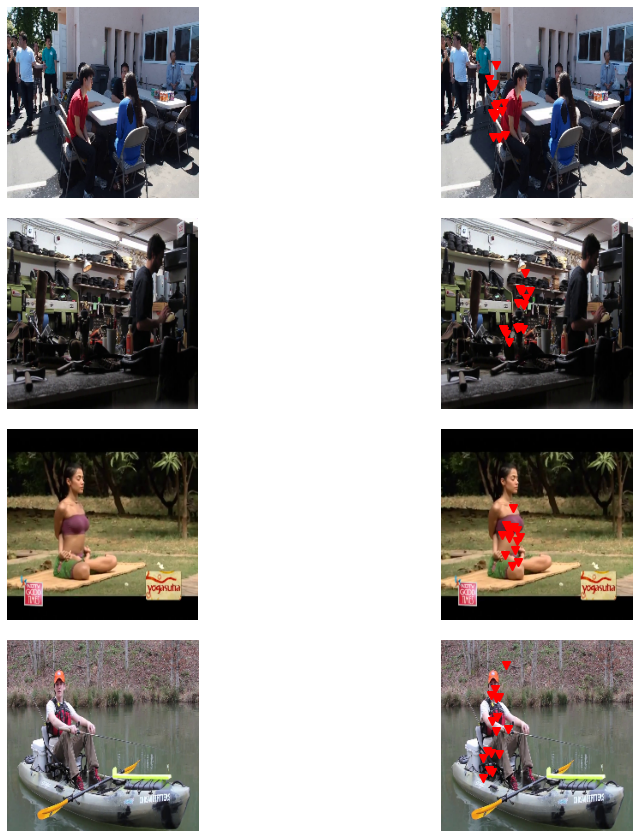

In [21]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 16, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 16, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)


In [22]:
backbone.trainable = True
model.load_weights('saved_model/finetuned_model.h5')

1/1 [==============================] - 0s 25ms/step


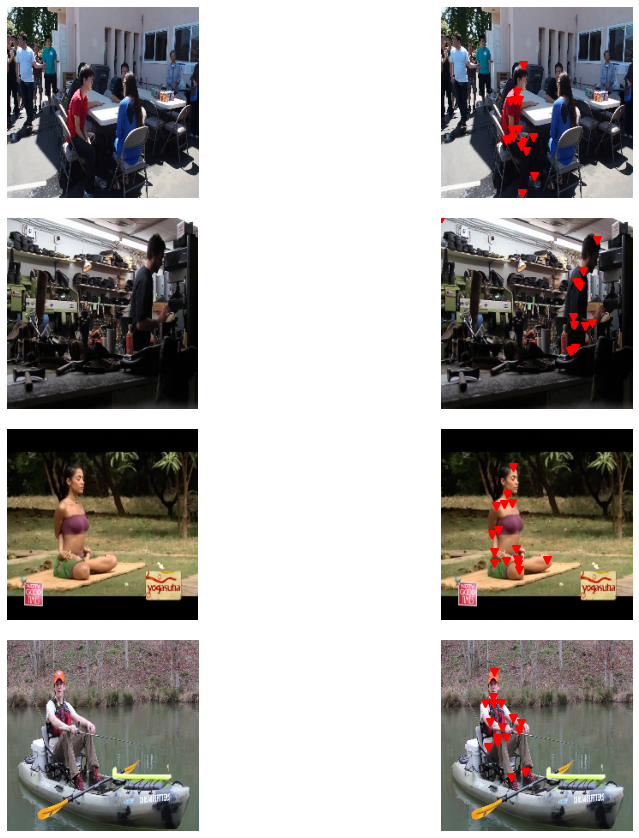

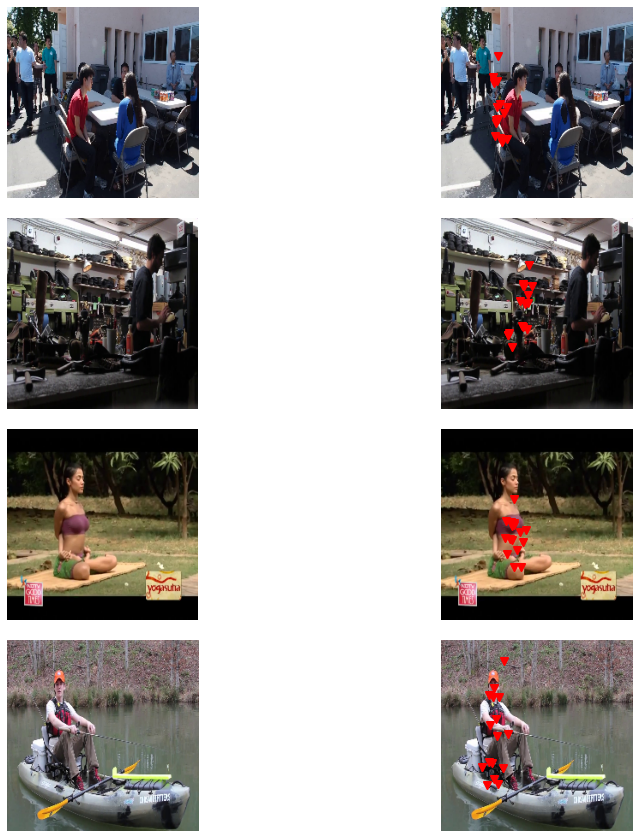

In [23]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 16, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 16, 2) * IMG_SIZE

visualize_keypoints(sample_val_images, sample_val_keypoints)

visualize_keypoints(sample_val_images, predictions)
